# Introduction

> Use the `keras` from Tensorflow to build ANN model that would fit the credit score data and be able to generalize well.

Use the Credit Score Classification dataset provided [here](https://www.kaggle.com/datasets/parisrohan/credit-score-classification) to train and test your design.

**Notes:**
- Split the data as you see fit and use validation during training.
- You may re-use the EDA, data preparation, and other sections you previously used in ML projects repo.
- Remember that you can use classification metrics from other libraries as well (e.g., `sklearn`)
- Plot the loss, and accuracy against epochs and extract insights on how well of a fit your model is.
- This time the notebook is not prepared with sections and instructions so that you can do it yourself.
- If you are stuck, you can consult the [Keras User Guide](https://keras.io/api/). There are some useful [Code Examples](https://keras.io/examples/) as well.


# Old Prepartion (skip)

## `01` Import Necessary Libraries

### `i` Default Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

### `ii` Additional Libraries
Add imports for additional libraries you used throughout the notebook

In [2]:
from sklearn.impute import  KNNImputer
from sklearn.preprocessing import OrdinalEncoder, MultiLabelBinarizer, StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.svm import  LinearSVC , SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

----------------

## `02` Data Preparation

In [3]:
train = pd.read_csv('Data/train.csv')

C:\Users\hp\AppData\Local\Temp\ipykernel_11924\1109336967.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('Data/train.csv')


Perform data cleaning, feature engineering, scaling, dropping unwanted columns (such as IDs), etc. as needed to make sure it's ready for the model.

`Q` Is this dataset *skewed*?

Hints:
- It could be helpful to check `sklearn.preprocessing` module.
- Remember that Support Vector Machine classifiers require special preprocessing.

In [4]:
def remove_underscores_and_convert(df, col, to_float=True):
    df[col] = df[col].astype(str).str.replace('_', '', regex=False)
    if to_float:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def process_type_of_loan(df):
    df['Type_of_Loan'] = df['Type_of_Loan'].astype(str).str.replace(' and ', ', ')
    df['Type_of_Loan'] = df['Type_of_Loan'].str.split(', ')
    df['Type_of_Loan'] = df['Type_of_Loan'].apply(lambda x: [item.strip().rstrip(',') for item in x] if isinstance(x, list) else [])
    mlb = MultiLabelBinarizer()
    one_hot_encoded = pd.DataFrame(mlb.fit_transform(df['Type_of_Loan']), columns=mlb.classes_)
    df = pd.concat([df, one_hot_encoded], axis=1).drop(columns=['Type_of_Loan','nan'])
    return df

In [5]:
X = train.drop('Credit_Score', axis=1)
y = train['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)
#aX_train = X_train
#ay_train = y_train

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (90000, 27)
X_test shape: (10000, 27)
y_train shape: (90000,)
y_test shape: (10000,)


In [6]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

#### General processing

In [7]:
def preprocess(df, test=False, Ordinal_encoder=None, Knnimputer=None, Scaler=None):
    drop_cols = ['ID', 'Customer_ID', 'Name', 'SSN', 'Month', 'Credit_History_Age']
    remove_underscore_cols = ["Annual_Income", "Num_of_Loan", "Num_of_Delayed_Payment", "Outstanding_Debt", "Age"]
    Oe_col = ["Occupation", "Payment_of_Min_Amount", "Credit_Mix", "Payment_Behaviour"]

    df = df.drop(drop_cols, axis=1)

    for col in remove_underscore_cols:
        df = remove_underscores_and_convert(df, col)

    replacements = {
        "Occupation": "_______",
        "Credit_Mix": "_",
        "Amount_invested_monthly": "__10000__",
        "Monthly_Balance": "__-333333333333333333333333333__",
        "Changed_Credit_Limit": "_",
        "Payment_Behaviour": "!@9#%8",
        "Payment_of_Min_Amount": "NM"
    }

    for col, val in replacements.items():
        df[col] = df[col].replace(val, np.nan)

    numeric_cols = ['Amount_invested_monthly', 'Monthly_Balance', 'Changed_Credit_Limit']
    df[numeric_cols] = df[numeric_cols].astype(float)

    if test:
        df[Oe_col] = Ordinal_encoder.transform(df[Oe_col])
    else:
        Oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        df[Oe_col] = Oe.fit_transform(df[Oe_col])

    df = process_type_of_loan(df)

    df['Age'] = df['Age'].apply(lambda x: x if 21 <= x <= 60 else np.nan)

    for col in numeric_cols + ['Age']:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].apply(lambda x: np.nan if x < lower_bound or x > upper_bound else x)
    
    if test:
        df = pd.DataFrame(Knnimputer.transform(df), columns=df.columns)
        df = pd.DataFrame(Scaler.transform(df), columns=df.columns)
        
        return df
    else:
        KnnImputer = KNNImputer(n_neighbors=5)
        df = pd.DataFrame(KnnImputer.fit_transform(df), columns=df.columns)
        
        scaler = StandardScaler()
        df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
        
        return df, Oe, KnnImputer, scaler


In [8]:
X_train, Oe, KnnImputer, scaler = preprocess(X_train, test=False)
X_train.head()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Monthly_Balance,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Not Specified,Payday Loan,Personal Loan,Student Loan
0,-0.747784,0.716107,-0.082978,0.088124,-0.145136,-0.120429,-0.135852,-0.015260,0.399073,-0.131647,...,1.163486,-0.662839,-0.682721,-0.6723,-0.675246,1.481248,-0.680623,-0.685399,-0.671743,1.491604
1,-1.415025,0.481033,-0.073170,0.609457,-0.094152,-0.151235,-0.116521,-0.031281,0.331777,-0.117921,...,2.385372,-0.662839,-0.682721,-0.6723,-0.675246,1.481248,-0.680623,-0.685399,-0.671743,-0.670419
2,1.587559,-0.365235,-0.101276,-0.566753,-0.077157,-0.143534,2.439558,-0.031281,0.129888,-0.081320,...,-0.979554,-0.662839,-0.682721,-0.6723,-0.675246,-0.675107,-0.680623,-0.685399,1.488665,-0.670419
3,-0.747784,-1.399563,-0.096537,-0.355755,-0.111146,-0.166638,-0.144444,0.000761,-1.148742,-0.104196,...,-0.068981,1.508663,-0.682721,-0.6723,-0.675246,1.481248,1.469241,-0.685399,-0.671743,-0.670419
4,-0.525371,-0.459265,-0.024052,2.450227,-0.102649,-0.135832,-0.133704,-0.031281,-0.744964,-0.072170,...,1.287544,-0.662839,-0.682721,-0.6723,-0.675246,1.481248,-0.680623,-0.685399,-0.671743,-0.670419


In [9]:
y_scaler = OrdinalEncoder()
y_train = pd.DataFrame(y_train)
y_train = pd.DataFrame(y_scaler.fit_transform(y_train), columns=["Credit_Score"])
y_train.head()

,Credit_Score
0,1.0
1,2.0
2,2.0
3,0.0
4,0.0


In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=1234)

print(f"X_train shape: {X_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_train shape: (76500, 29)
X_valid shape: (13500, 29)
y_train shape: (76500, 1)
y_valid shape: (13500, 1)


### `#` Prepare Test Set

Apply the data transformations you used on the training set to the test set.

**Important Note:** DO NOT use `fit` on the test set.

In [11]:
X_test = preprocess(X_test, test=True, Ordinal_encoder=Oe, Knnimputer=KnnImputer, Scaler=scaler)
X_test.head()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Monthly_Balance,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Not Specified,Payday Loan,Personal Loan,Student Loan
0,-0.747784,0.481033,-0.081358,0.302606,-0.060163,-0.112728,-0.088597,0.064843,1.744999,-0.035569,...,-2.137019,-0.662839,-0.682721,1.487431,-0.675246,-0.675107,1.469241,1.459004,1.488665,1.491604
1,1.031525,0.010884,-0.116065,-1.020759,-0.111146,-0.143534,-0.131556,0.064843,-0.004705,-0.049294,...,-0.865823,-0.662839,1.464726,1.487431,1.480942,1.481248,-0.680623,1.459004,1.488665,-0.670419
2,-1.526232,-0.929414,-0.112466,-0.978525,-0.060163,-0.097325,-0.095041,0.032802,0.197184,-0.053869,...,-0.975500,1.508663,1.464726,1.487431,-0.675246,-0.675107,1.469241,-0.685399,-0.671743,-0.670419
3,-1.303818,0.245958,-0.049041,1.511015,-0.128141,8.797780,-0.148740,-1.649364,-0.610371,-0.127072,...,-0.101551,-0.662839,-0.682721,-0.672300,-0.675246,1.481248,1.469241,1.459004,-0.671743,-0.670419
4,0.253077,-0.929414,-0.089610,-0.129409,-0.068660,-0.097325,-0.112225,0.032802,1.273925,-0.044719,...,-0.257090,-0.662839,1.464726,-0.672300,1.480942,1.481248,-0.680623,-0.685399,1.488665,1.491604


In [12]:
y_test = pd.DataFrame(y_test)
y_test = pd.DataFrame(y_scaler.transform(y_test), columns=["Credit_Score"])
y_test.head()

,Credit_Score
0,1.0
1,2.0
2,1.0
3,0.0
4,2.0


In [13]:
y_train.Credit_Score.value_counts()

Credit_Score
2.0    40782
1.0    22139
0.0    13579
Name: count, dtype: int64

In [14]:
from sklearn.feature_selection import mutual_info_classif
import numpy as np

mi_scores = mutual_info_classif(X_train, y_train)
for i, score in enumerate(mi_scores):
    print(f"Feature {i}: {score:.4f}")


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Feature 0: 0.0226
Feature 1: 0.0000
Feature 2: 0.5911
Feature 3: 0.4929
Feature 4: 0.1006
Feature 5: 0.1115
Feature 6: 0.1684
Feature 7: 0.0838
Feature 8: 0.1232
Feature 9: 0.0896
Feature 10: 0.0981
Feature 11: 0.1114
Feature 12: 0.1778
Feature 13: 0.5902
Feature 14: 0.0000
Feature 15: 0.1206
Feature 16: 0.5201
Feature 17: 0.0146
Feature 18: 0.0077
Feature 19: 0.0431
Feature 20: 0.0152
Feature 21: 0.0125
Feature 22: 0.0119
Feature 23: 0.0154
Feature 24: 0.0127
Feature 25: 0.0161
Feature 26: 0.0146
Feature 27: 0.0113
Feature 28: 0.0119


,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Payment_of_Min_Amount,Total_EMI_per_month
40654,-0.114700,-0.924533,-0.119644,-0.143534,-0.120816,-0.072001,-0.144754,0.992642,-0.641520,-1.229629,-0.167533
8184,-0.082479,0.208717,-0.077157,-0.135832,-0.088597,2.485258,-0.108155,-1.561807,0.150553,0.839679,-0.137203
41857,-0.112730,-0.868736,-0.111146,-0.128131,-0.122964,-0.610371,-0.108155,0.481752,-0.489641,0.839679,2.153619
88223,-0.081921,0.188397,-0.111146,-0.128131,-0.133704,-0.812260,-0.118612,0.992642,-1.054524,0.839679,-0.152944
14836,-0.092557,-0.214369,-0.111146,-0.158936,-0.146592,-1.014149,-0.123840,-0.284583,-0.697373,-1.229629,-0.169697
...,...,...,...,...,...,...,...,...,...,...,...
82584,-0.115762,-1.008501,-0.111146,-0.112728,-0.101485,-0.139297,-0.087242,0.992642,0.062486,0.839679,-0.168521
89460,-0.092985,-0.194829,-0.111146,-0.128131,-0.140148,-0.004705,-0.144754,-0.284583,-0.107447,-1.229629,3.198327
60620,-0.068693,0.763182,-0.111146,-0.135832,-0.129408,-0.408482,-0.134297,-0.029138,-0.777136,-1.229629,-0.163013
34086,-0.062232,0.885950,-0.119644,-0.135832,-0.153036,-1.417927,-0.108155,-0.284583,0.006338,-1.229629,-0.139847


In [ ]:
important_features = [2,3,4,5,6,8,11,12,13,15,16]
X_train = X_train.iloc[:, important_features]
X_valid = X_valid.iloc[:, important_features]
X_test = X_test.iloc[:, important_features]
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(76500, 11)
(13500, 11)
(10000, 11)


# Deep Learining

## ANN

In [59]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



keras.utils.set_random_seed(4)

In [60]:
inputs = Input(shape=(X_train.shape[1],))
x = layers.Dense(32, activation="relu")(inputs)
x = layers.BatchNormalization()(x)

skip_1 = layers.Dense(32, activation="relu")(inputs)
x = layers.Add()([x, skip_1])
x = layers.ReLU()(x)

x = layers.Dense(16, activation="relu")(x)
x = layers.BatchNormalization()(x)

skip_2 = layers.Dense(16, activation="relu")(skip_1)
x = layers.Add()([x, skip_2])
x = layers.ReLU()(x)

x = layers.Dense(8, activation="relu")(x)
x = layers.BatchNormalization()(x)

skip_3 = layers.Dense(8, activation="relu")(skip_2)
x = layers.Add()([x, skip_3])
x = layers.ReLU()(x)

outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=30, min_delta=0.0001)
rop = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_delta=0.0001)
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, use_ema=True)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 11)]                 0         []                            
                                                                                                  
 dense_52 (Dense)            (None, 32)                   384       ['input_10[0][0]']            
                                                                                                  
 batch_normalization_16 (Ba  (None, 32)                   128       ['dense_52[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 dense_53 (Dense)            (None, 32)                   384       ['input_10[0][0]']      

In [61]:
history = model.fit(X_train, y_train, epochs=5000,batch_size=128, validation_data=(X_valid, y_valid),callbacks=[es, rop], verbose=1)

Epoch 1/5000
598/598 [==============================] - 6s 5ms/step - loss: 0.8370 - accuracy: 0.5920 - val_loss: 0.7567 - val_accuracy: 0.6356 - lr: 0.0010
Epoch 2/5000
598/598 [==============================] - 2s 4ms/step - loss: 0.7484 - accuracy: 0.6433 - val_loss: 0.7390 - val_accuracy: 0.6530 - lr: 0.0010
Epoch 3/5000
598/598 [==============================] - 2s 4ms/step - loss: 0.7378 - accuracy: 0.6491 - val_loss: 0.7364 - val_accuracy: 0.6518 - lr: 0.0010
Epoch 4/5000
598/598 [==============================] - 2s 4ms/step - loss: 0.7319 - accuracy: 0.6526 - val_loss: 0.7289 - val_accuracy: 0.6600 - lr: 0.0010
Epoch 5/5000
598/598 [==============================] - 2s 4ms/step - loss: 0.7285 - accuracy: 0.6563 - val_loss: 0.7268 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 6/5000
598/598 [==============================] - 2s 4ms/step - loss: 0.7260 - accuracy: 0.6596 - val_loss: 0.7233 - val_accuracy: 0.6623 - lr: 0.0010
Epoch 7/5000
598/598 [==============================] - 2s

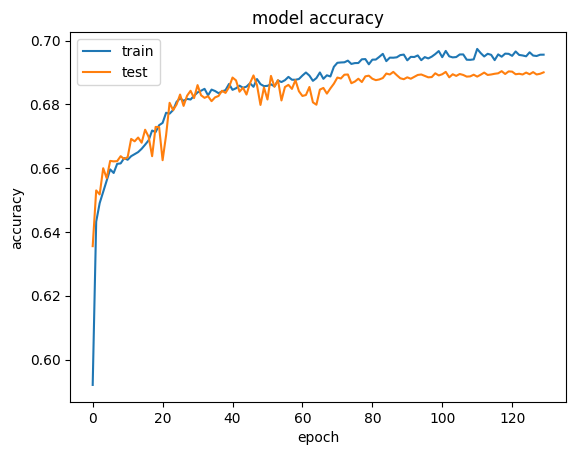

In [62]:
#plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

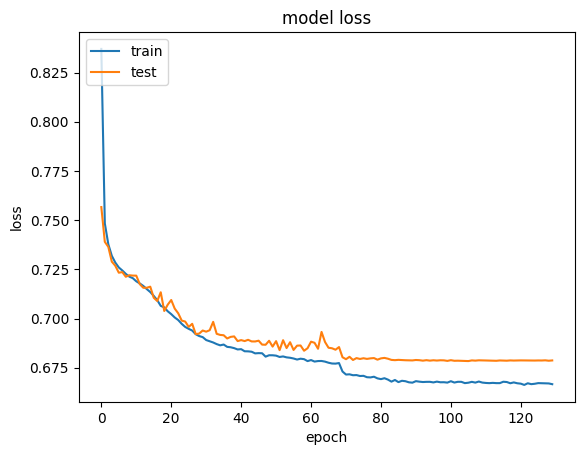

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [64]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
print(classification_report(y_test, pred))

313/313 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

         0.0       0.57      0.64      0.60      1823
         1.0       0.70      0.66      0.68      2913
         2.0       0.73      0.72      0.72      5264

    accuracy                           0.69     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.69      0.69      0.69     10000

